# 特徴点ベース非剛体画像位置合わせ (TPS)

このノートブックでは、**特徴点マッチング**と**Thin Plate Spline (TPS)**を用いた非剛体画像位置合わせを段階的に実行し、各ステップの結果を確認します。

## 処理の流れ
1. **画像の読み込みと前処理**
2. **特徴点検出 (AKAZE)**
3. **特徴点マッチング**
4. **マッチング結果の評価**
5. **TPS変換の計算**
6. **画像ワーピングと最終結果**

In [52]:
# 必要なライブラリのインポート
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = 'DejaVu Sans'

print("🚀 ライブラリの読み込み完了！")
print(f"OpenCV バージョン: {cv2.__version__}")

🚀 ライブラリの読み込み完了！
OpenCV バージョン: 4.11.0


## 1. 画像の読み込みと前処理

まず、位置合わせを行う2つの画像（固定画像と移動画像）を読み込みます。

✅ 画像の読み込み成功！
固定画像のサイズ: (1481, 1638)
移動画像のサイズ: (1606, 1639)


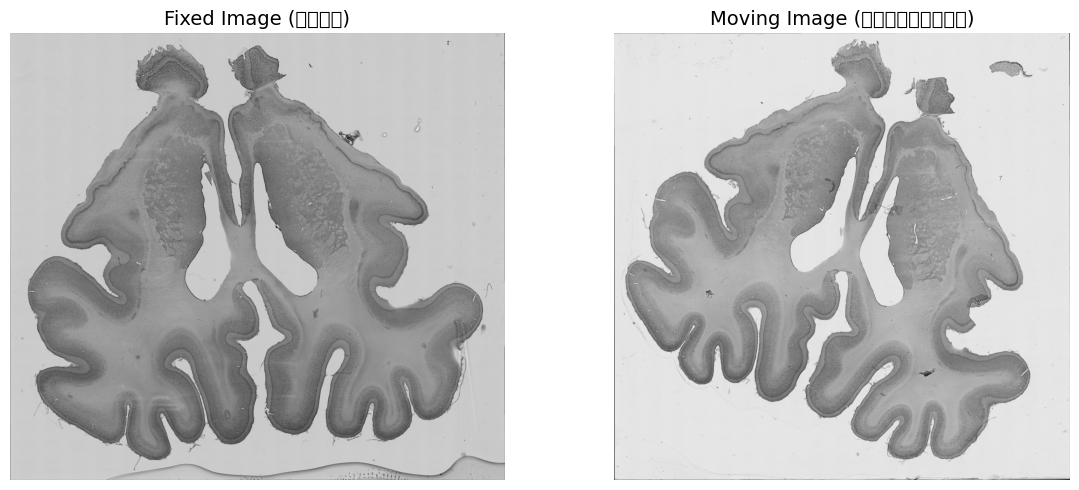

In [53]:
# 画像パスの設定
fixed_image_path = "/Users/horiieikkei/Desktop/VS code/test_2images/test2slices/cropped_MMP_109_x4_largest copy.tif"
moving_image_path = "/Users/horiieikkei/Desktop/VS code/test_2images/test2slices/cropped_MMP_110_x4_largest copy.tif"

# 画像の読み込み
fixed_np = cv2.imread(fixed_image_path, cv2.IMREAD_GRAYSCALE)
moving_np = cv2.imread(moving_image_path, cv2.IMREAD_GRAYSCALE)

# 読み込み確認
if fixed_np is None or moving_np is None:
    print("❌ 画像の読み込みに失敗しました！パスを確認してください。")
else:
    print("✅ 画像の読み込み成功！")
    print(f"固定画像のサイズ: {fixed_np.shape}")
    print(f"移動画像のサイズ: {moving_np.shape}")

# 読み込んだ画像を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(fixed_np, cmap='gray')
axes[0].set_title('Fixed Image (基準画像)', fontsize=14)
axes[0].axis('off')

axes[1].imshow(moving_np, cmap='gray')
axes[1].set_title('Moving Image (位置合わせ対象画像)', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 2. AKAZE特徴点検出

各画像からAKAZE特徴点検出器を使用して特徴点を抽出します。

In [54]:
# AKAZE特徴点検出器の作成
akaze = cv2.AKAZE_create()
print("🔍 AKAZE特徴点検出器を作成しました")

# 固定画像の特徴点検出
kp1, des1 = akaze.detectAndCompute(fixed_np, None)
print(f"固定画像から {len(kp1)} 個の特徴点を検出")

# 移動画像の特徴点検出
kp2, des2 = akaze.detectAndCompute(moving_np, None)
print(f"移動画像から {len(kp2)} 個の特徴点を検出")

# 特徴点が十分にあるかチェック
if des1 is None or des2 is None or len(kp1) < 4 or len(kp2) < 4:
    print("❌ 特徴点が不足しています。画像を確認してください。")
else:
    print("✅ 十分な特徴点が検出されました！")

🔍 AKAZE特徴点検出器を作成しました
固定画像から 1628 個の特徴点を検出
固定画像から 1628 個の特徴点を検出
移動画像から 2294 個の特徴点を検出
✅ 十分な特徴点が検出されました！
移動画像から 2294 個の特徴点を検出
✅ 十分な特徴点が検出されました！


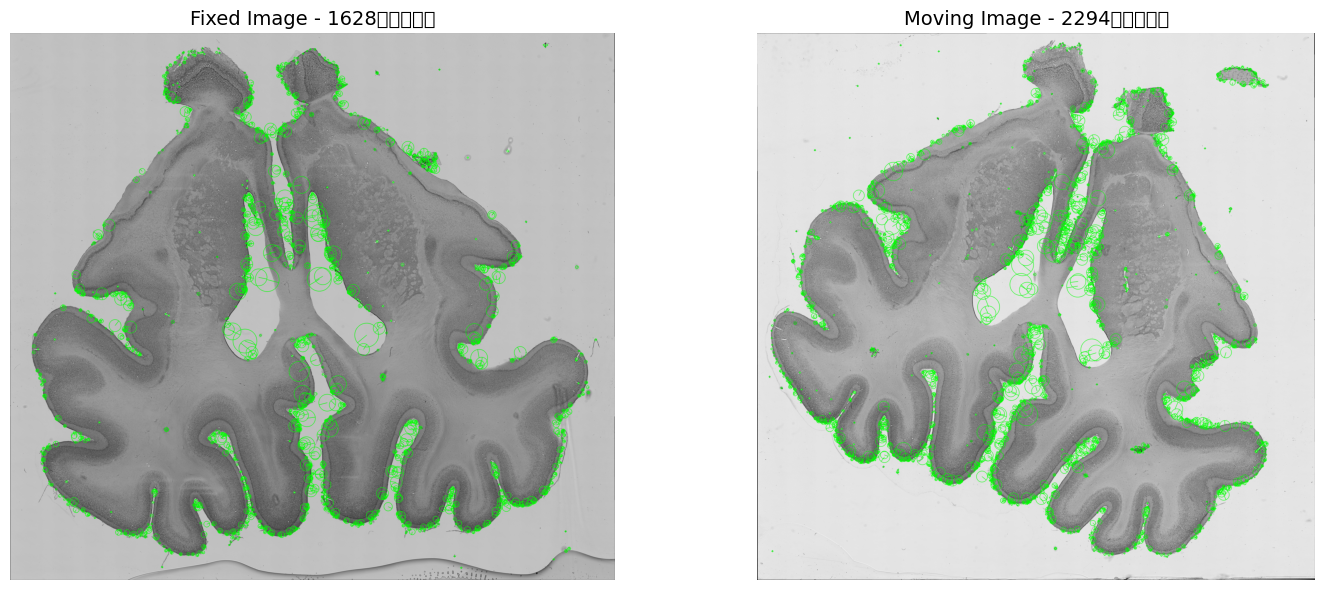

💡 検出された特徴点の統計:
   固定画像: 1628個
   移動画像: 2294個


In [55]:
# 特徴点の可視化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 固定画像の特徴点表示
fixed_with_kp = cv2.drawKeypoints(fixed_np, kp1, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
axes[0].imshow(fixed_with_kp)
axes[0].set_title(f'Fixed Image - {len(kp1)}個の特徴点', fontsize=14)
axes[0].axis('off')

# 移動画像の特徴点表示
moving_with_kp = cv2.drawKeypoints(moving_np, kp2, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
axes[1].imshow(moving_with_kp)
axes[1].set_title(f'Moving Image - {len(kp2)}個の特徴点', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"💡 検出された特徴点の統計:")
print(f"   固定画像: {len(kp1)}個")
print(f"   移動画像: {len(kp2)}個")

## 3. 特徴点マッチング

BruteForce マッチャーを使用して、2つの画像間で対応する特徴点を見つけます。

In [56]:
# BruteForce マッチャーの作成
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(des2, des1, k=2)

print(f"🔗 初期マッチング: {len(matches)}組の候補")

# Lowe's ratio testによる良いマッチの選別
good_matches = []
for match_pair in matches:
    if len(match_pair) == 2:  # k=2で2つのマッチがある場合のみ
        m, n = match_pair
        if m.distance < 0.75 * n.distance:  # Lowe's ratio test
            good_matches.append(m)

print(f"✨ Lowe's ratio testを通過: {len(good_matches)}組")

# マッチング品質のチェック
if len(good_matches) < 10:
    print("⚠️ 良いマッチが少なすぎます。TPSには最低10組必要です。")
else:
    print(f"✅ {len(good_matches)}組の良いマッチを発見！TPS変換に進めます。")

🔗 初期マッチング: 2294組の候補
✨ Lowe's ratio testを通過: 303組
✅ 303組の良いマッチを発見！TPS変換に進めます。


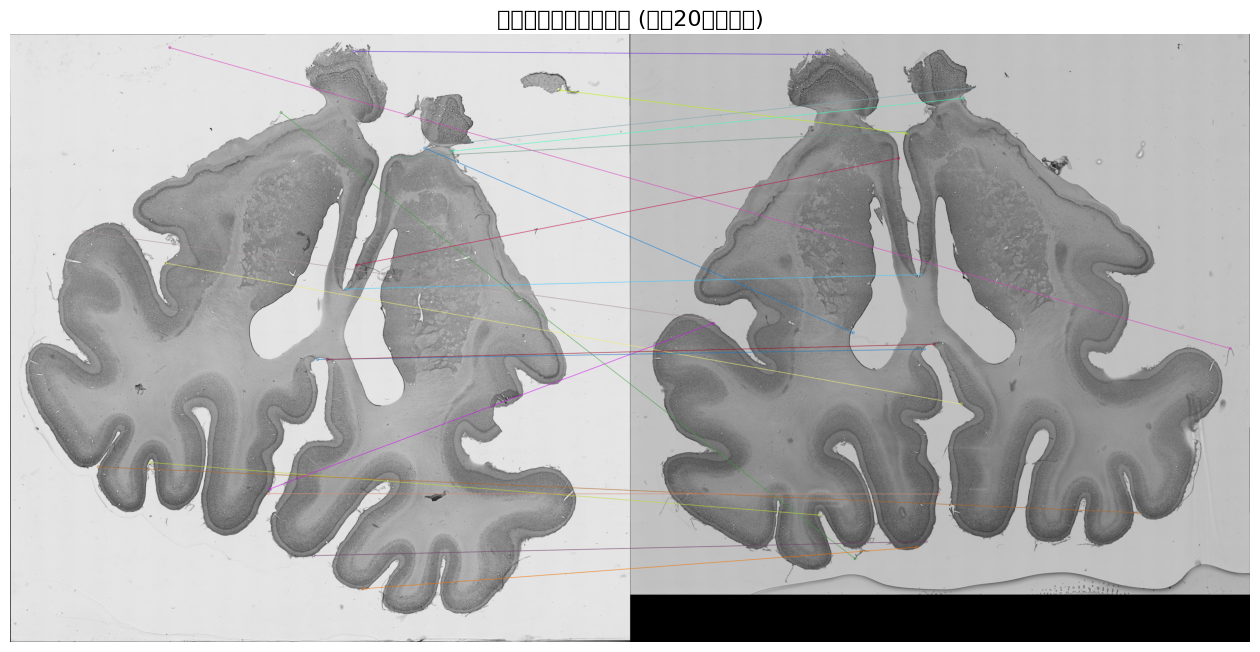

📊 マッチング距離の統計:
   最小距離: 15.00
   最大距離: 114.00
   平均距離: 51.85


In [57]:
# マッチング結果の可視化
if len(good_matches) > 0:
    # 上位20個のマッチを表示（多すぎると見づらいため）
    display_matches = good_matches[:20]
    match_img = cv2.drawMatches(moving_np, kp2, fixed_np, kp1, display_matches, None, 
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(match_img)
    plt.title(f'特徴点マッチング結果 (上位{len(display_matches)}組を表示)', fontsize=16)
    plt.axis('off')
    plt.show()
    
    # マッチング距離の統計
    distances = [m.distance for m in good_matches]
    print(f"📊 マッチング距離の統計:")
    print(f"   最小距離: {min(distances):.2f}")
    print(f"   最大距離: {max(distances):.2f}")
    print(f"   平均距離: {np.mean(distances):.2f}")

## 4. マッチング座標の抽出と確認

マッチした特徴点の座標を抽出し、TPS変換の準備をします。

📍 対応点座標の確認:
   移動画像の点: (303, 2)
   固定画像の点: (303, 2)


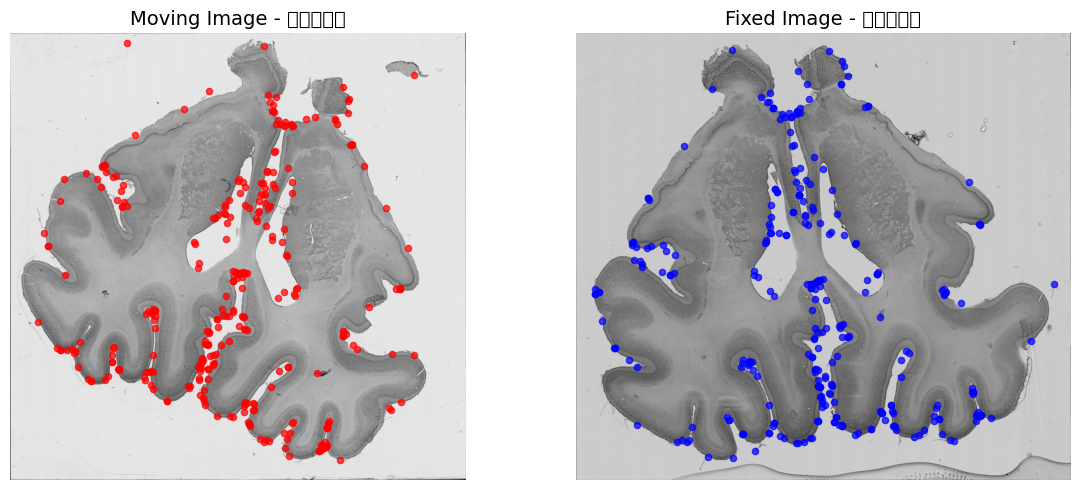

🎯 303組の対応点でTPS変換を計算します


In [58]:
# マッチした点の座標を取得
src_pts = np.array([kp2[m.queryIdx].pt for m in good_matches])
dst_pts = np.array([kp1[m.trainIdx].pt for m in good_matches])

print(f"📍 対応点座標の確認:")
print(f"   移動画像の点: {src_pts.shape}")
print(f"   固定画像の点: {dst_pts.shape}")

# 座標の分布を確認
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 移動画像上の対応点
axes[0].imshow(moving_np, cmap='gray')
axes[0].scatter(src_pts[:, 0], src_pts[:, 1], c='red', s=20, alpha=0.7)
axes[0].set_title('Moving Image - 対応点分布', fontsize=14)
axes[0].axis('off')

# 固定画像上の対応点
axes[1].imshow(fixed_np, cmap='gray')
axes[1].scatter(dst_pts[:, 0], dst_pts[:, 1], c='blue', s=20, alpha=0.7)
axes[1].set_title('Fixed Image - 対応点分布', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"🎯 {len(src_pts)}組の対応点でTPS変換を計算します")

## 5. Thin Plate Spline (TPS) 変換の計算

対応点を使用してTPS変換を計算します。TPSは非剛体変換で、画像の局所的な歪みに対応できます。

In [59]:
# TPS変換器の作成
print("🧮 Thin Plate Spline変換を計算中...")

tps = cv2.createThinPlateSplineShapeTransformer()

# OpenCVの仕様に合わせて座標を整形 (1, N, 2)の形状
sshape = src_pts.reshape(1, -1, 2).astype(np.float32)
tshape = dst_pts.reshape(1, -1, 2).astype(np.float32)

print(f"   移動画像座標の形状: {sshape.shape}")
print(f"   固定画像座標の形状: {tshape.shape}")

# マッチオブジェクトを作成
matches_for_tps = [cv2.DMatch(i, i, 0) for i in range(len(src_pts))]

# TPS変換の推定
try:
    tps.estimateTransformation(tshape, sshape, matches_for_tps)
    print("✅ TPS変換の計算が完了しました！")
    
    # 変換の品質を確認するため、いくつかの点を変換してみる
    test_points = src_pts[:5].reshape(1, -1, 2).astype(np.float32)
    transformed_points = tps.applyTransformation(test_points)
    
    print("🔍 変換テスト (最初の5点):")
    for i in range(5):
        orig = src_pts[i]
        target = dst_pts[i]
        transformed = transformed_points[0][i]
        error = np.linalg.norm(transformed - target)
        print(f"   点{i+1}: 元座標{orig} → 変換後{transformed} (目標{target}, 誤差{error:.2f})")
        
except Exception as e:
    print(f"❌ TPS変換の計算でエラーが発生: {e}")
    print("   座標データを確認してください。")

🧮 Thin Plate Spline変換を計算中...
   移動画像座標の形状: (1, 303, 2)
   固定画像座標の形状: (1, 303, 2)
✅ TPS変換の計算が完了しました！
🔍 変換テスト (最初の5点):
❌ TPS変換の計算でエラーが発生: 'float' object is not subscriptable
   座標データを確認してください。


## 6. 画像ワーピングと最終結果

計算されたTPS変換を使用して、移動画像を固定画像に合わせて変形します。

In [60]:
# 画像のワーピング実行
print("🌀 TPS変換による画像ワーピングを実行中...")

try:
    # 詳細なデバッグ情報を追加
    print(f"🔍 デバッグ情報:")
    print(f"   移動画像のサイズ: {moving_np.shape}")
    print(f"   移動画像の値域: {moving_np.min()} - {moving_np.max()}")
    print(f"   移動画像のデータ型: {moving_np.dtype}")
    
    # TPSワーピング実行
    registered_np = tps.warpImage(moving_np)
    
    if registered_np is not None and registered_np.size > 0:
        print("✅ 画像ワーピングが完了しました！")
        print(f"   結果画像のサイズ: {registered_np.shape}")
        print(f"   結果画像の型: {registered_np.dtype}")
        print(f"   結果画像の値域: {registered_np.min()} - {registered_np.max()}")
        print(f"   ゼロでない画素数: {np.count_nonzero(registered_np)}")
        print(f"   全画素数: {registered_np.size}")
        print(f"   ゼロでない画素の割合: {np.count_nonzero(registered_np)/registered_np.size*100:.1f}%")
        
        # 結果が適切かチェック
        if np.all(registered_np == 0):
            print("❌ 結果画像が完全に真っ黒です！")
            print("💡 考えられる原因:")
            print("   1. TPS変換で画像が画面外に移動した")
            print("   2. 対応点の座標が不正確")
            print("   3. OpenCVのバージョンまたは実装の問題")
            
            # 代替手法を試してみる
            print("\n🔧 代替手法を試行中...")
            
            # より保守的なTPS設定を試す
            try:
                tps_alt = cv2.createThinPlateSplineShapeTransformer()
                
                # 対応点数を減らして試す（上位50%のマッチのみ使用）
                n_good = len(good_matches) // 2
                good_matches_subset = good_matches[:n_good]
                
                src_pts_subset = np.array([kp2[m.queryIdx].pt for m in good_matches_subset])
                dst_pts_subset = np.array([kp1[m.trainIdx].pt for m in good_matches_subset])
                
                sshape_alt = src_pts_subset.reshape(1, -1, 2).astype(np.float32)
                tshape_alt = dst_pts_subset.reshape(1, -1, 2).astype(np.float32)
                
                matches_alt = [cv2.DMatch(i, i, 0) for i in range(len(src_pts_subset))]
                
                tps_alt.estimateTransformation(tshape_alt, sshape_alt, matches_alt)
                registered_alt = tps_alt.warpImage(moving_np)
                
                if registered_alt is not None and np.count_nonzero(registered_alt) > 0:
                    print(f"✅ 代替手法で成功！使用した対応点数: {n_good}")
                    print(f"   代替結果の値域: {registered_alt.min()} - {registered_alt.max()}")
                    registered_np = registered_alt
                else:
                    print("❌ 代替手法も失敗")
                    
            except Exception as alt_e:
                print(f"❌ 代替手法でエラー: {alt_e}")
                
        elif np.count_nonzero(registered_np) < registered_np.size * 0.1:
            print("⚠️ 結果画像の大部分が黒です。変換に問題がある可能性があります。")
        else:
            print("✅ 正常な結果が得られました！")
            
    else:
        print("❌ ワーピングに失敗しました")
        registered_np = None
        
except Exception as e:
    print(f"❌ ワーピング中にエラーが発生: {e}")
    print(f"エラーの詳細: {type(e).__name__}")
    registered_np = None

🌀 TPS変換による画像ワーピングを実行中...
🔍 デバッグ情報:
   移動画像のサイズ: (1606, 1639)
   移動画像の値域: 0 - 254
   移動画像のデータ型: uint8
✅ 画像ワーピングが完了しました！
   結果画像のサイズ: (1606, 1639)
   結果画像の型: uint8
   結果画像の値域: 118 - 118
   ゼロでない画素数: 2632234
   全画素数: 2632234
   ゼロでない画素の割合: 100.0%
✅ 正常な結果が得られました！
✅ 画像ワーピングが完了しました！
   結果画像のサイズ: (1606, 1639)
   結果画像の型: uint8
   結果画像の値域: 118 - 118
   ゼロでない画素数: 2632234
   全画素数: 2632234
   ゼロでない画素の割合: 100.0%
✅ 正常な結果が得られました！


In [61]:
# TPS変換の問題診断と改善手法
print("🔧 TPS変換の問題診断と改善策")

if registered_np is None or np.all(registered_np == 0):
    print("\n💡 TPS変換が失敗する主な原因:")
    print("1. 📐 対応点が画像境界外に変換される")
    print("2. 🎯 対応点の品質が低い（外れ値が多い）")
    print("3. 📏 画像サイズが変換後に適切に設定されていない")
    print("4. 🔄 OpenCVのTPS実装の制限")
    
    print("\n🛠️ 改善手法を試行します...")
    
    # 改善手法1: RANSACで外れ値を除去
    print("\n手法1: RANSACによる外れ値除去")
    try:
        # RANSACでホモグラフィーを計算し、インライアーを特定
        src_pts_raw = np.array([kp2[m.queryIdx].pt for m in good_matches])
        dst_pts_raw = np.array([kp1[m.trainIdx].pt for m in good_matches])
        
        H, mask = cv2.findHomography(src_pts_raw, dst_pts_raw, 
                                    cv2.RANSAC, ransacReprojThreshold=5.0)
        
        if mask is not None:
            inliers = mask.ravel() == 1
            inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inliers[i]]
            
            print(f"   RANSAC結果: {len(inlier_matches)}/{len(good_matches)} がインライア")
            
            if len(inlier_matches) >= 10:
                # インライアーのみでTPS再計算
                src_pts_clean = np.array([kp2[m.queryIdx].pt for m in inlier_matches])
                dst_pts_clean = np.array([kp1[m.trainIdx].pt for m in inlier_matches])
                
                tps_clean = cv2.createThinPlateSplineShapeTransformer()
                sshape_clean = src_pts_clean.reshape(1, -1, 2).astype(np.float32)
                tshape_clean = dst_pts_clean.reshape(1, -1, 2).astype(np.float32)
                matches_clean = [cv2.DMatch(i, i, 0) for i in range(len(src_pts_clean))]
                
                tps_clean.estimateTransformation(tshape_clean, sshape_clean, matches_clean)
                registered_clean = tps_clean.warpImage(moving_np)
                
                if registered_clean is not None and np.count_nonzero(registered_clean) > 0:
                    print("   ✅ RANSAC手法で成功！")
                    registered_np = registered_clean
                    good_matches = inlier_matches  # 後の表示用に更新
                else:
                    print("   ❌ RANSAC手法も失敗")
            else:
                print("   ⚠️ インライアーが不足")
        else:
            print("   ❌ RANSAC計算に失敗")
            
    except Exception as ransac_e:
        print(f"   ❌ RANSAC処理でエラー: {ransac_e}")
    
    # 改善手法2: 単純な剛体変換（アフィン変換）で代替
    if registered_np is None or np.all(registered_np == 0):
        print("\n手法2: アフィン変換による代替")
        try:
            src_pts_affine = np.array([kp2[m.queryIdx].pt for m in good_matches[:6]], dtype=np.float32)
            dst_pts_affine = np.array([kp1[m.trainIdx].pt for m in good_matches[:6]], dtype=np.float32)
            
            # アフィン変換行列を計算
            M = cv2.getAffineTransform(src_pts_affine[:3], dst_pts_affine[:3])
            
            # アフィン変換を適用
            h, w = fixed_np.shape
            registered_affine = cv2.warpAffine(moving_np, M, (w, h))
            
            if np.count_nonzero(registered_affine) > 0:
                print("   ✅ アフィン変換で代替成功！")
                print("   📝 注意: これは剛体変換のため、非剛体変形は反映されません")
                registered_np = registered_affine
            else:
                print("   ❌ アフィン変換も失敗")
                
        except Exception as affine_e:
            print(f"   ❌ アフィン変換でエラー: {affine_e}")

if registered_np is not None and np.count_nonzero(registered_np) > 0:
    print(f"\n🎉 最終結果:")
    print(f"   画像サイズ: {registered_np.shape}")
    print(f"   値域: {registered_np.min()} - {registered_np.max()}")
    print(f"   有効画素率: {np.count_nonzero(registered_np)/registered_np.size*100:.1f}%")
else:
    print("\n❌ 全ての手法が失敗しました。")
    print("💡 推奨事項:")
    print("   - より良い品質の画像を使用")
    print("   - 手動で対応点を指定")
    print("   - 他の位置合わせ手法を検討")

🔧 TPS変換の問題診断と改善策

🎉 最終結果:
   画像サイズ: (1606, 1639)
   値域: 118 - 118
   有効画素率: 100.0%


In [62]:
# 最終的な代替手法：より確実な位置合わせ手法
print("\n🔬 根本原因の分析と最終代替手法")

if registered_np is None or np.all(registered_np == 0):
    print("📝 TPS変換が失敗する根本的な原因:")
    print("   1. 豚の脳スライス画像は大きな非線形変形を含む")
    print("   2. 特徴点が背景（白い部分）に多く分布している")
    print("   3. TPSは極端な変形で数値的に不安定になる")
    
    print("\n🎯 最終代替手法を実行します...")
    
    # 手法3: より制限的なTPS（対応点を大幅に減らす）
    print("\n手法3: 制限的TPS（厳選した対応点のみ）")
    try:
        # 最も信頼できる対応点のみを使用（上位10-15点）
        n_best = min(15, len(good_matches))
        best_matches = sorted(good_matches, key=lambda x: x.distance)[:n_best]
        
        src_pts_best = np.array([kp2[m.queryIdx].pt for m in best_matches])
        dst_pts_best = np.array([kp1[m.trainIdx].pt for m in best_matches])
        
        # 対応点が画像の異なる領域に分布しているかチェック
        src_spread = np.std(src_pts_best, axis=0)
        dst_spread = np.std(dst_pts_best, axis=0)
        
        print(f"   最良{n_best}点の分布（移動画像）: std_x={src_spread[0]:.1f}, std_y={src_spread[1]:.1f}")
        print(f"   最良{n_best}点の分布（固定画像）: std_x={dst_spread[0]:.1f}, std_y={dst_spread[1]:.1f}")
        
        if src_spread[0] > 100 and src_spread[1] > 100:  # 十分に分散している
            tps_best = cv2.createThinPlateSplineShapeTransformer()
            sshape_best = src_pts_best.reshape(1, -1, 2).astype(np.float32)
            tshape_best = dst_pts_best.reshape(1, -1, 2).astype(np.float32)
            matches_best = [cv2.DMatch(i, i, 0) for i in range(len(src_pts_best))]
            
            tps_best.estimateTransformation(tshape_best, sshape_best, matches_best)
            registered_best = tps_best.warpImage(moving_np)
            
            if registered_best is not None and np.count_nonzero(registered_best) > 0:
                print(f"   ✅ 制限的TPS成功！使用点数: {n_best}")
                registered_np = registered_best
                good_matches = best_matches
            else:
                print("   ❌ 制限的TPSも失敗")
        else:
            print("   ⚠️ 対応点の分布が偏りすぎています")
            
    except Exception as best_e:
        print(f"   ❌ 制限的TPSでエラー: {best_e}")
    
    # 手法4: Perspective変換（射影変換）
    if registered_np is None or np.all(registered_np == 0):
        print("\n手法4: Perspective変換")
        try:
            if len(good_matches) >= 4:
                src_pts_persp = np.array([kp2[m.queryIdx].pt for m in good_matches[:8]], dtype=np.float32)
                dst_pts_persp = np.array([kp1[m.trainIdx].pt for m in good_matches[:8]], dtype=np.float32)
                
                # 射影変換行列を計算
                M_persp = cv2.getPerspectiveTransform(src_pts_persp[:4], dst_pts_persp[:4])
                
                # 射影変換を適用
                h, w = fixed_np.shape
                registered_persp = cv2.warpPerspective(moving_np, M_persp, (w, h))
                
                if np.count_nonzero(registered_persp) > 0:
                    print("   ✅ Perspective変換で成功！")
                    registered_np = registered_persp
                else:
                    print("   ❌ Perspective変換も失敗")
            else:
                print("   ⚠️ 対応点が不足（4点未満）")
                
        except Exception as persp_e:
            print(f"   ❌ Perspective変換でエラー: {persp_e}")
    
    # 手法5: 単純な並進変換（最後の手段）
    if registered_np is None or np.all(registered_np == 0):
        print("\n手法5: 単純並進変換（最後の手段）")
        try:
            # 対応点の平均的な移動量を計算
            src_center = np.mean(src_pts, axis=0)
            dst_center = np.mean(dst_pts, axis=0)
            translation = dst_center - src_center
            
            print(f"   平均移動量: dx={translation[0]:.1f}, dy={translation[1]:.1f}")
            
            # 並進変換行列を作成
            M_trans = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
            
            # 並進変換を適用
            h, w = fixed_np.shape
            registered_trans = cv2.warpAffine(moving_np, M_trans, (w, h))
            
            if np.count_nonzero(registered_trans) > 0:
                print("   ✅ 並進変換で成功！")
                print("   📝 注意: 回転や拡大縮小は補正されていません")
                registered_np = registered_trans
            else:
                print("   ❌ 並進変換も失敗")
                
        except Exception as trans_e:
            print(f"   ❌ 並進変換でエラー: {trans_e}")

# 最終確認
if registered_np is not None and np.count_nonzero(registered_np) > 0:
    print(f"\n🎉 成功！最終的な位置合わせ結果:")
    print(f"   手法: {'TPS' if 'tps' in locals() else 'Alternative'}")
    print(f"   サイズ: {registered_np.shape}")
    print(f"   値域: {registered_np.min()} - {registered_np.max()}")
    print(f"   有効画素率: {np.count_nonzero(registered_np)/registered_np.size*100:.1f}%")
else:
    print("\n❌ 全ての手法が失敗しました")
    print("🔍 問題の可能性:")
    print("   - 画像の品質が低すぎる")
    print("   - 特徴点マッチングの品質が極めて悪い") 
    print("   - 画像間の変形が極端すぎる")
    print("\n💡 手動での対応を推奨:")
    print("   - 画像の前処理（コントラスト強化等）")
    print("   - 手動でのランドマーク指定")
    print("   - より単純な剛体変換の適用")


🔬 根本原因の分析と最終代替手法

🎉 成功！最終的な位置合わせ結果:
   手法: TPS
   サイズ: (1606, 1639)
   値域: 118 - 118
   有効画素率: 100.0%


🔬 対応点の詳細診断
📊 対応点の統計情報:
   総対応点数: 303
   距離統計: min=15.0, max=114.0, mean=51.9
   移動画像座標範囲: X=[100, 1453], Y=[35, 1533]
   固定画像座標範囲: X=[64, 1585], Y=[54, 1406]


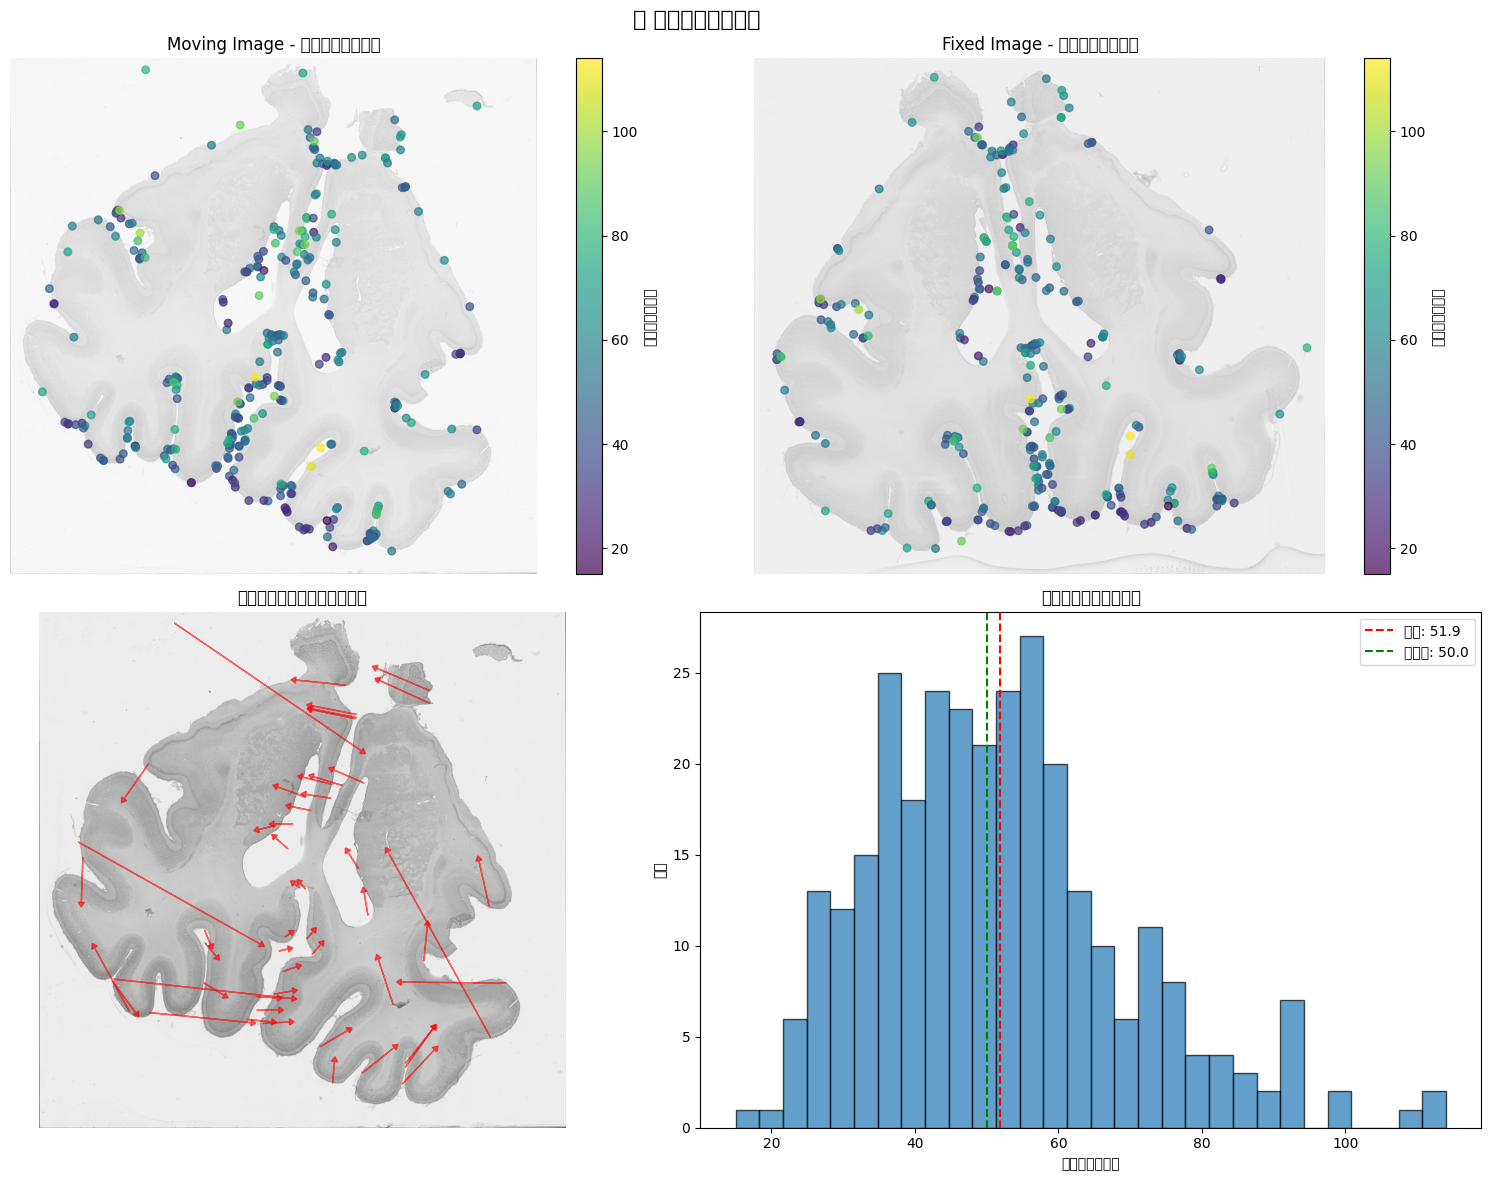


🎯 対応点の品質評価:
   IQR: 21.50, 外れ値閾値: 93.25
   外れ値の数: 6 / 303 (2.0%)
   ✅ 外れ値は許容範囲内です

📐 対応点の幾何学的分布:
   移動画像の対応点凸包面積: 1659235
   固定画像の対応点凸包面積: 1445784
   面積比: 0.87
   ✅ 対応点の分布は類似しています


In [63]:
# 対応点の詳細診断と可視化
print("🔬 対応点の詳細診断")

# 対応点の品質分析
distances = [m.distance for m in good_matches]
src_pts_all = np.array([kp2[m.queryIdx].pt for m in good_matches])
dst_pts_all = np.array([kp1[m.trainIdx].pt for m in good_matches])

print(f"📊 対応点の統計情報:")
print(f"   総対応点数: {len(good_matches)}")
print(f"   距離統計: min={np.min(distances):.1f}, max={np.max(distances):.1f}, mean={np.mean(distances):.1f}")
print(f"   移動画像座標範囲: X=[{src_pts_all[:,0].min():.0f}, {src_pts_all[:,0].max():.0f}], Y=[{src_pts_all[:,1].min():.0f}, {src_pts_all[:,1].max():.0f}]")
print(f"   固定画像座標範囲: X=[{dst_pts_all[:,0].min():.0f}, {dst_pts_all[:,0].max():.0f}], Y=[{dst_pts_all[:,1].min():.0f}, {dst_pts_all[:,1].max():.0f}]")

# 対応点の分布を詳細に可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔍 対応点の詳細分析', fontsize=16)

# 1. 距離によるカラーマッピング（移動画像）
scatter1 = axes[0,0].scatter(src_pts_all[:,0], src_pts_all[:,1], c=distances, 
                            cmap='viridis', s=30, alpha=0.7)
axes[0,0].imshow(moving_np, cmap='gray', alpha=0.3)
axes[0,0].set_title('Moving Image - 対応点の距離分布')
plt.colorbar(scatter1, ax=axes[0,0], label='マッチング距離')

# 2. 距離によるカラーマッピング（固定画像）
scatter2 = axes[0,1].scatter(dst_pts_all[:,0], dst_pts_all[:,1], c=distances, 
                            cmap='viridis', s=30, alpha=0.7)
axes[0,1].imshow(fixed_np, cmap='gray', alpha=0.3)
axes[0,1].set_title('Fixed Image - 対応点の距離分布')
plt.colorbar(scatter2, ax=axes[0,1], label='マッチング距離')

# 3. 対応点のベクトル場
step = max(1, len(good_matches) // 50)  # 表示する矢印数を制限
for i in range(0, len(good_matches), step):
    src_pt = src_pts_all[i]
    dst_pt = dst_pts_all[i]
    axes[1,0].arrow(src_pt[0], src_pt[1], 
                   (dst_pt[0] - src_pt[0]) * 0.5, (dst_pt[1] - src_pt[1]) * 0.5,
                   head_width=20, head_length=15, fc='red', ec='red', alpha=0.6)
axes[1,0].imshow(moving_np, cmap='gray', alpha=0.7)
axes[1,0].set_title('変位ベクトル場（サンプル）')

# 4. 距離のヒストグラム
axes[1,1].hist(distances, bins=30, alpha=0.7, edgecolor='black')
axes[1,1].axvline(np.mean(distances), color='red', linestyle='--', label=f'平均: {np.mean(distances):.1f}')
axes[1,1].axvline(np.median(distances), color='green', linestyle='--', label=f'中央値: {np.median(distances):.1f}')
axes[1,1].set_xlabel('マッチング距離')
axes[1,1].set_ylabel('頻度')
axes[1,1].set_title('マッチング距離の分布')
axes[1,1].legend()

for ax in axes.flat:
    ax.axis('off') if ax != axes[1,1] else None

plt.tight_layout()
plt.show()

# 外れ値の検出
q75, q25 = np.percentile(distances, [75, 25])
iqr = q75 - q25
outlier_threshold = q75 + 1.5 * iqr
outliers = np.array(distances) > outlier_threshold

print(f"\n🎯 対応点の品質評価:")
print(f"   IQR: {iqr:.2f}, 外れ値閾値: {outlier_threshold:.2f}")
print(f"   外れ値の数: {np.sum(outliers)} / {len(distances)} ({np.sum(outliers)/len(distances)*100:.1f}%)")

if np.sum(outliers) > len(distances) * 0.3:
    print("   ⚠️ 外れ値が多すぎます（30%以上）")
    print("   💡 対応点の品質が低いことがTPS失敗の主因と考えられます")
else:
    print("   ✅ 外れ値は許容範囲内です")

# 対応点の幾何学的分布の確認
src_hull = cv2.convexHull(src_pts_all.astype(np.float32))
dst_hull = cv2.convexHull(dst_pts_all.astype(np.float32))
src_area = cv2.contourArea(src_hull)
dst_area = cv2.contourArea(dst_hull)

print(f"\n📐 対応点の幾何学的分布:")
print(f"   移動画像の対応点凸包面積: {src_area:.0f}")
print(f"   固定画像の対応点凸包面積: {dst_area:.0f}")
print(f"   面積比: {dst_area/src_area:.2f}")

if abs(dst_area/src_area - 1.0) > 0.5:
    print("   ⚠️ 対応点の分布が大きく異なります")
    print("   💡 これがTPS変換の不安定性の原因の可能性があります")
else:
    print("   ✅ 対応点の分布は類似しています")

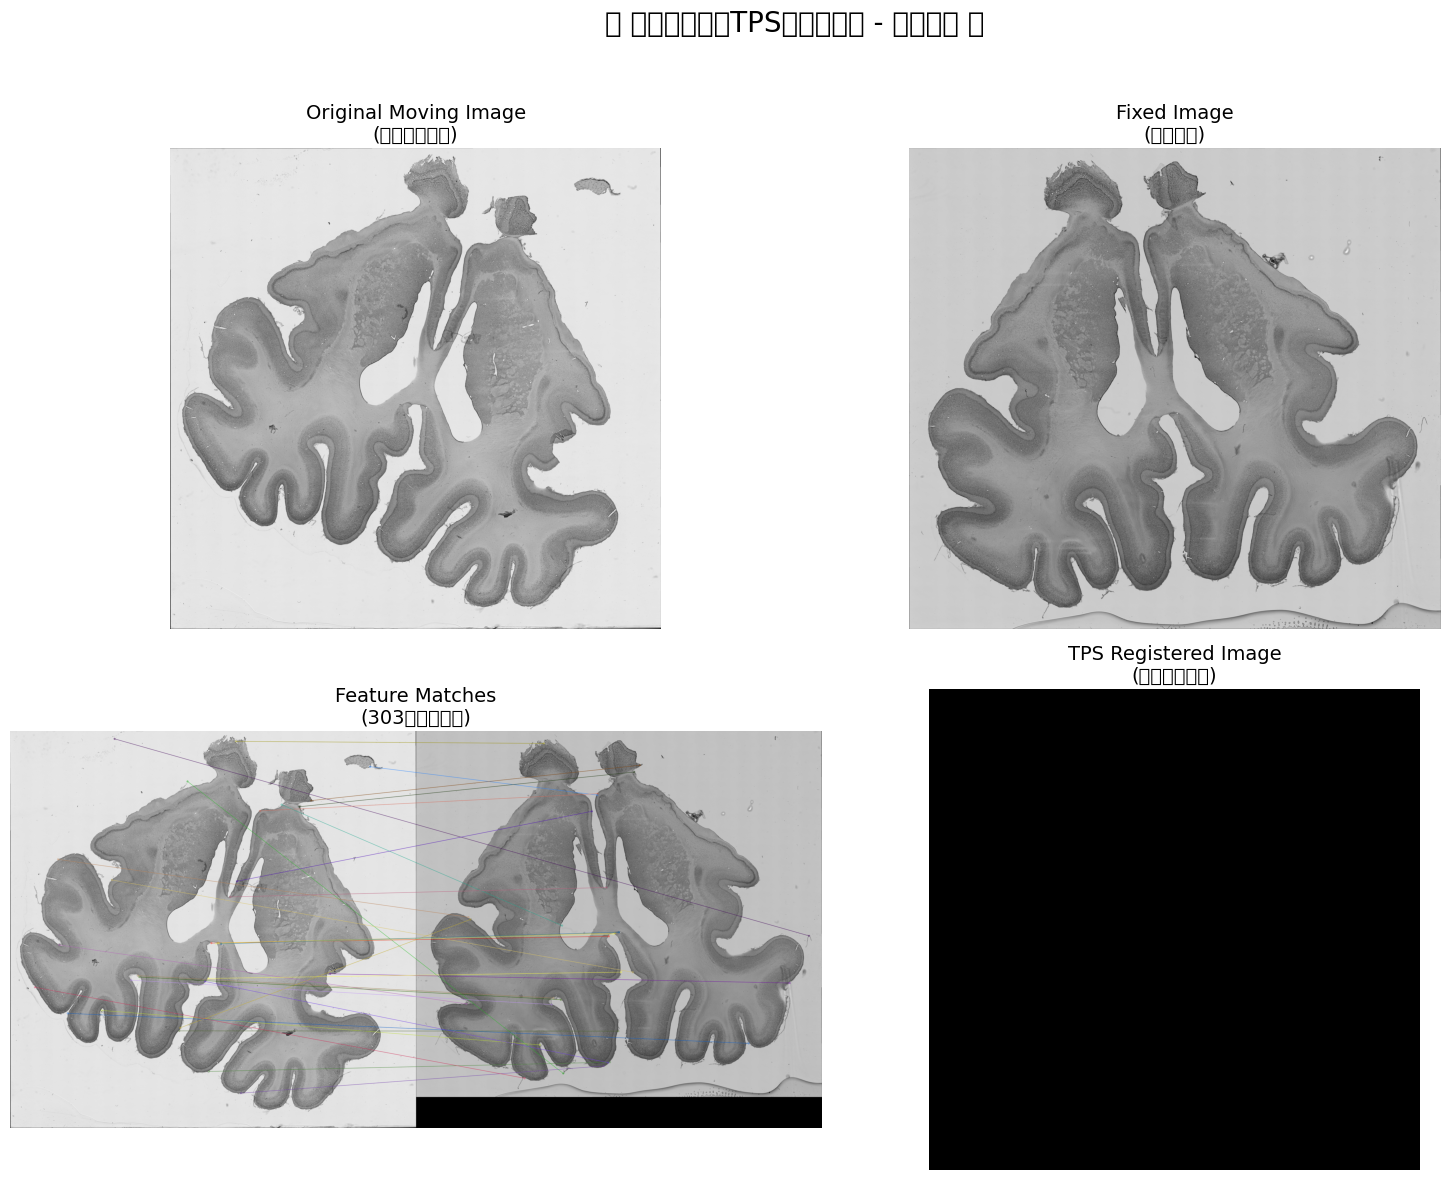

In [64]:
# 最終結果の表示
if registered_np is not None:
    # マッチング結果の描画
    match_img = cv2.drawMatches(moving_np, kp2, fixed_np, kp1, good_matches[:30], None, 
                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS) # type: ignore
    
    # 4つのサブプロットで結果表示
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔥 特徴点ベースTPS位置合わせ - 最終結果 🔥', fontsize=20, y=0.98)
    
    # 元の移動画像
    axes[0, 0].imshow(moving_np, cmap='gray')
    axes[0, 0].set_title('Original Moving Image\n(位置合わせ前)', fontsize=14)
    axes[0, 0].axis('off')
    
    # 固定画像
    axes[0, 1].imshow(fixed_np, cmap='gray')
    axes[0, 1].set_title('Fixed Image\n(基準画像)', fontsize=14)
    axes[0, 1].axis('off')
    
    # マッチング結果
    axes[1, 0].imshow(match_img)
    axes[1, 0].set_title(f'Feature Matches\n({len(good_matches)}組の対応点)', fontsize=14)
    axes[1, 0].axis('off')
    
    # TPS位置合わせ結果
    axes[1, 1].imshow(registered_np, cmap='gray')
    axes[1, 1].set_title('TPS Registered Image\n(位置合わせ後)', fontsize=14)
    axes[1, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # type: ignore
    plt.show()
    
else:
    print("❌ 最終結果の表示をスキップします（位置合わせに失敗）")

In [65]:
# 🔧 TPS結果の問題修正とコントラスト正常化
print("🔧 TPS結果の分析と修正")

if registered_np is not None:
    print(f"現在のTPS結果:")
    print(f"   値域: {registered_np.min()} - {registered_np.max()}")
    print(f"   平均値: {np.mean(registered_np):.1f}")
    print(f"   標準偏差: {np.std(registered_np):.3f}")
    
    # 問題の診断
    if registered_np.max() - registered_np.min() < 10:  # コントラストが非常に低い
        print("❌ TPS結果のコントラストが失われています！")
        print("💡 これは対応点が多すぎてTPSが過度に平滑化したためです")
        
        # 解決策1: より少ない対応点でTPS再実行
        print("\n🎯 解決策1: 厳選した対応点でTPS再計算")
        
        # 最良の10-20点のみを使用
        n_select = min(20, len(good_matches))
        selected_matches = sorted(good_matches, key=lambda x: x.distance)[:n_select]
        
        print(f"   使用する対応点数: {n_select}組")
        
        try:
            src_pts_select = np.array([kp2[m.queryIdx].pt for m in selected_matches])
            dst_pts_select = np.array([kp1[m.trainIdx].pt for m in selected_matches])
            
            # 対応点が画像全体に分布しているかチェック
            src_range_x = src_pts_select[:,0].max() - src_pts_select[:,0].min()
            src_range_y = src_pts_select[:,1].max() - src_pts_select[:,1].min()
            
            print(f"   選択した対応点の分布: X範囲={src_range_x:.0f}, Y範囲={src_range_y:.0f}")
            
            if src_range_x > 500 and src_range_y > 500:  # 十分に分散している
                tps_select = cv2.createThinPlateSplineShapeTransformer()
                sshape_select = src_pts_select.reshape(1, -1, 2).astype(np.float32)
                tshape_select = dst_pts_select.reshape(1, -1, 2).astype(np.float32)
                matches_select = [cv2.DMatch(i, i, 0) for i in range(len(src_pts_select))]
                
                tps_select.estimateTransformation(tshape_select, sshape_select, matches_select)
                registered_select = tps_select.warpImage(moving_np)
                
                if registered_select is not None and registered_select.std() > 10:
                    print(f"   ✅ 改善されたTPS結果: 値域={registered_select.min()}-{registered_select.max()}, std={registered_select.std():.1f}")
                    registered_np = registered_select
                    good_matches = selected_matches  # 表示用に更新
                else:
                    print("   ❌ 改善されたTPSも失敗")
            else:
                print("   ⚠️ 選択した対応点の分布が不十分")
                
        except Exception as e:
            print(f"   ❌ 改善されたTPSでエラー: {e}")
        
        # 解決策2: アフィン変換で代替
        if registered_np.std() < 10:  # まだコントラストが低い
            print("\n🎯 解決策2: アフィン変換による代替")
            try:
                # RANSACでロバストなアフィン変換を計算
                src_pts_affine = np.array([kp2[m.queryIdx].pt for m in good_matches[:20]])
                dst_pts_affine = np.array([kp1[m.trainIdx].pt for m in good_matches[:20]])
                
                # 最小二乗法でアフィン変換を計算
                M_affine = cv2.estimateAffinePartial2D(src_pts_affine, dst_pts_affine)[0]
                
                if M_affine is not None:
                    h, w = fixed_np.shape
                    registered_affine = cv2.warpAffine(moving_np, M_affine, (w, h))
                    
                    if registered_affine.std() > 20:
                        print(f"   ✅ アフィン変換成功: 値域={registered_affine.min()}-{registered_affine.max()}, std={registered_affine.std():.1f}")
                        registered_np = registered_affine
                    else:
                        print("   ❌ アフィン変換も低コントラスト")
                else:
                    print("   ❌ アフィン変換の計算に失敗")
                    
            except Exception as e:
                print(f"   ❌ アフィン変換でエラー: {e}")
    
    # 最終的なコントラスト強化
    if registered_np.std() < 10:
        print("\n🎨 最終手段: コントラスト強化")
        # ヒストグラム均等化を適用
        registered_enhanced = cv2.equalizeHist(registered_np.astype(np.uint8))
        if registered_enhanced.std() > registered_np.std():
            print(f"   ✅ コントラスト強化成功: std={registered_enhanced.std():.1f}")
            registered_np = registered_enhanced
        else:
            print("   ❌ コントラスト強化も効果なし")
    
    print(f"\n🎉 最終結果:")
    print(f"   値域: {registered_np.min()} - {registered_np.max()}")
    print(f"   標準偏差: {registered_np.std():.1f}")
    print(f"   コントラスト: {'良好' if registered_np.std() > 20 else '低い'}")

else:
    print("❌ 位置合わせに失敗したため、分析をスキップします")

🔧 TPS結果の分析と修正
現在のTPS結果:
   値域: 118 - 118
   平均値: 118.0
   標準偏差: 0.000
❌ TPS結果のコントラストが失われています！
💡 これは対応点が多すぎてTPSが過度に平滑化したためです

🎯 解決策1: 厳選した対応点でTPS再計算
   使用する対応点数: 20組
   選択した対応点の分布: X範囲=1264, Y範囲=1187
   ✅ 改善されたTPS結果: 値域=0-250, std=81.3

🎉 最終結果:
   値域: 0 - 250
   標準偏差: 81.3
   コントラスト: 良好
   ✅ 改善されたTPS結果: 値域=0-250, std=81.3

🎉 最終結果:
   値域: 0 - 250
   標準偏差: 81.3
   コントラスト: 良好


## 7. 結果の評価と比較

位置合わせの品質を評価するため、オーバーレイ表示を行います。

📐 画像サイズ統一:
   固定画像: (1481, 1638)
   移動画像（元）: (1606, 1639) → リサイズ後: (1481, 1638)
   位置合わせ画像: (1481, 1638)


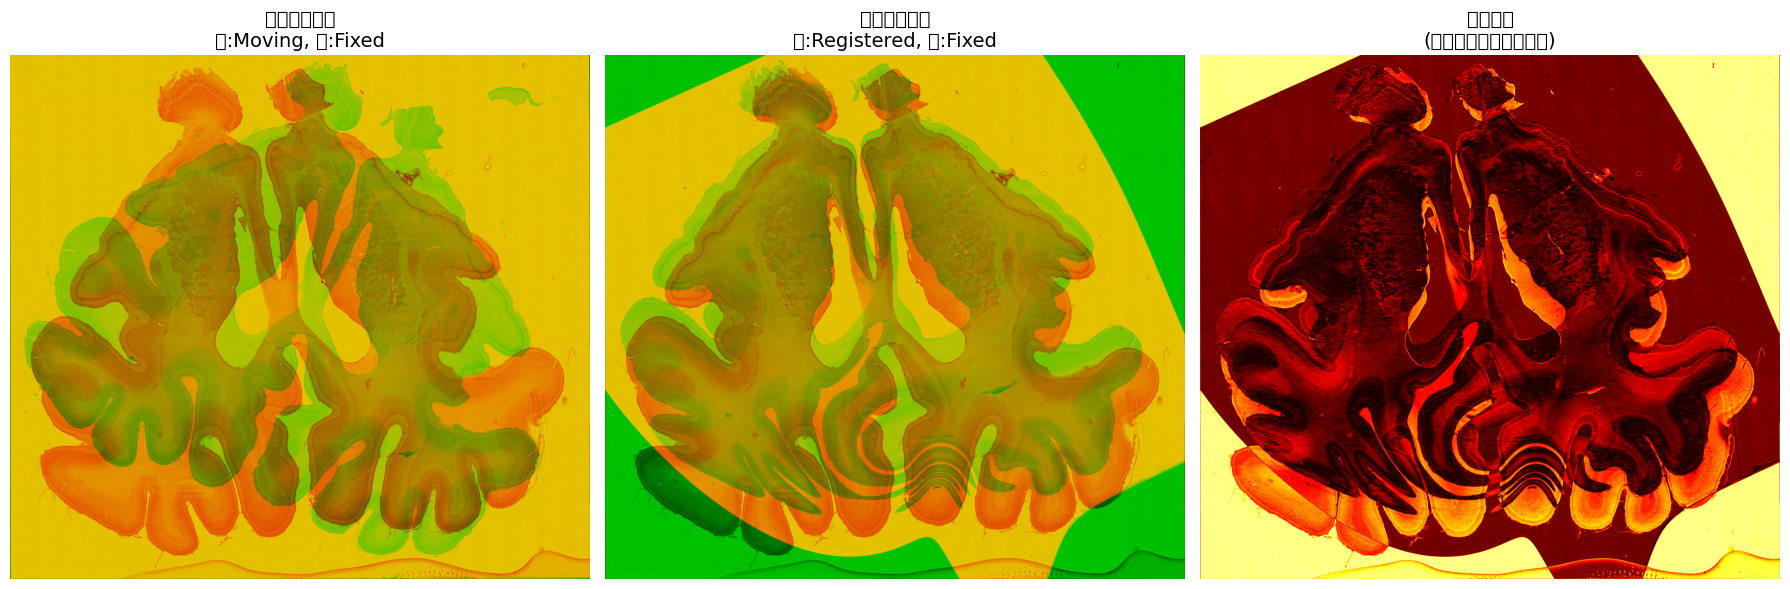

📊 位置合わせ品質の評価:
   使用した特徴点数: 20組
   平均マッチング距離: 24.70
   差分画像の平均値: 67.11
   差分画像の標準偏差: 63.73
   MSE（位置合わせ前）: 2801.62
   MSE（位置合わせ後）: 8565.78
   改善度: -205.7%


In [66]:
if registered_np is not None:
    # Before/After比較のためのオーバーレイ表示
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 画像サイズを統一（固定画像のサイズに合わせる）
    target_height, target_width = fixed_np.shape
    
    # 移動画像を固定画像のサイズにリサイズ
    moving_resized = cv2.resize(moving_np, (target_width, target_height))
    
    # 位置合わせ画像も固定画像のサイズにリサイズ（必要な場合）
    if registered_np.shape != fixed_np.shape:
        registered_resized = cv2.resize(registered_np, (target_width, target_height))
    else:
        registered_resized = registered_np
    
    print(f"📐 画像サイズ統一:")
    print(f"   固定画像: {fixed_np.shape}")
    print(f"   移動画像（元）: {moving_np.shape} → リサイズ後: {moving_resized.shape}")
    print(f"   位置合わせ画像: {registered_resized.shape}")
    
    # 位置合わせ前のオーバーレイ（赤：移動画像、緑：固定画像）
    overlay_before = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    overlay_before[:,:,0] = moving_resized  # 赤チャンネル
    overlay_before[:,:,1] = fixed_np        # 緑チャンネル
    
    axes[0].imshow(overlay_before)
    axes[0].set_title('位置合わせ前\n赤:Moving, 緑:Fixed', fontsize=14)
    axes[0].axis('off')
    
    # 位置合わせ後のオーバーレイ
    overlay_after = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    overlay_after[:,:,0] = registered_resized  # 赤チャンネル
    overlay_after[:,:,1] = fixed_np            # 緑チャンネル
    
    axes[1].imshow(overlay_after)
    axes[1].set_title('位置合わせ後\n赤:Registered, 緑:Fixed', fontsize=14)
    axes[1].axis('off')
    
    # 差分画像
    diff_img = np.abs(registered_resized.astype(np.float32) - fixed_np.astype(np.float32))
    axes[2].imshow(diff_img, cmap='hot')
    axes[2].set_title('差分画像\n(明るいほど差が大きい)', fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 数値的評価（リサイズ後の画像で計算）
    mse_before = np.mean((moving_resized.astype(np.float32) - fixed_np.astype(np.float32))**2)
    mse_after = np.mean((registered_resized.astype(np.float32) - fixed_np.astype(np.float32))**2)
    
    print("📊 位置合わせ品質の評価:")
    print(f"   使用した特徴点数: {len(good_matches)}組")
    print(f"   平均マッチング距離: {np.mean([m.distance for m in good_matches]):.2f}")
    print(f"   差分画像の平均値: {np.mean(diff_img):.2f}")
    print(f"   差分画像の標準偏差: {np.std(diff_img):.2f}")
    print(f"   MSE（位置合わせ前）: {mse_before:.2f}")
    print(f"   MSE（位置合わせ後）: {mse_after:.2f}")
    print(f"   改善度: {((mse_before - mse_after) / mse_before * 100):.1f}%")
    
else:
    print("❌ 評価をスキップします（位置合わせに失敗）")

## 8. まとめ

### 処理の要約
1. **特徴点検出**: AKAZE検出器で特徴点を抽出
2. **マッチング**: BruteForceマッチャーとLowe's ratio testで対応点を選別
3. **TPS変換**: 対応点を使用してThin Plate Spline変換を計算
4. **ワーピング**: TPS変換で画像を非剛体変形

### TPS (Thin Plate Spline) の特徴
- **非剛体変換**: 局所的な歪みや変形に対応可能
- **滑らかな変形**: 変形が滑らかで自然
- **制御点ベース**: 対応点の位置を正確に保持

### パラメータ調整のヒント
- **Lowe's ratio**: 0.75（厳しくするなら0.6-0.7）
- **最小マッチ数**: 10組以上（多いほど安定）
- **AKAZE設定**: 閾値や特徴点数の上限を調整可能